# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

<i>  <span style="color:#FFFF00; background:#00C000"> <b> Please download the notebook available as downloads in the <u>last unit of this section</u> </b> It will not run in the browser.</i>

#### Please download this Ipython notebook from the last unit of this section. We request you to run this Ipython Notebook on your local machine. You will not be able to run this Notebook on the Quantra portal as some of the cells are converted to RawNB format. When running this model on your system, please convert the cells in RawNBConvert format type to Code type, using the dropdown present in the menu bar of the Ipython Notebook.

# Model Solution: Combining the Agents and Strategy Analysis

This notebook is a model solution for the agent selection and strategy analysis of the capstone project. 

The model solution is structured as follows:

1. [Backtesting and model combination](#selection): The RL algorithm is run over the price three to five times to obtain different RL agents. A strategy is then built on the trained agents by allocating them portfolio weights based on their recent performance. The steps to combine the agents are:
    * [Loading the trained agents](#loading)
    * [Selecting the agents](#selecting)
    * [Get the agent returns](#returns)  
    * [Get the agent's rolling performance](#rolling)  
    * [Allocate portfolio weight based on the performance](#weights)
<br>
<br>

1. [Performance analysis](#performance): The strategy built by combining the agents is then backtested and the returns are analysed using the pyfolio package.
<br>
1. [Conclusion](#conclusion)

<a id='Import_modules'></a> 
## Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

import pandas as pd
import numpy as np
from datetime import timedelta
import pyfolio as pf

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/quantra_py_sync/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='Read_price_data'></a> 
## Read price data

In [2]:
# Read the price data
bars5m = pd.read_pickle('../data_modules/fx_pair_data_1.bz2')

# Display the last 5 entries of price data
bars5m.tail()

,open,high,low,close,volume
Time,,,,,
2020-07-24 23:45:00,0.710,0.710,0.710,0.710,5000.0
2020-07-24 23:50:00,0.710,0.710,0.710,0.710,5000.0
2020-07-24 23:55:00,0.710,0.710,0.710,0.710,5000.0
2020-07-25 00:00:00,0.710,0.710,0.710,0.710,4000.0
2020-07-27 00:00:00,0.709,0.709,0.709,0.709,324000.0


<a id='selection'></a> 
## Backtesting and model combination

We have run the RL agent in the previous notebook multiple times. Each time we changed the `WEIGHTS_FILE`, `TRADE_FILE` and the `REPLAY_FILE` filenames in the `rl_config` dictionary. When we have several models, we can compare their strategy returns. Then we can make a strategy using multiple RL agents, based on their performance.

The `trade_analytics` function used here is the same as we discussed earlier in the [notebook on Mixed Pattern: Model Learned Trending](https://www.quantra.quantinsti.com/startCourseDetails?cid=166&section_no=18&unit_no=13#course_type=paid&unit_type=Notebook).

Let's analyse the returns of the three agents which we have already trained.

In [3]:
def trade_analytics(trade_logs_file, price_data):
    """
    The analysis of trade performance is done in this function
    """

    # Read the trade logs file where we have already run the RL model on the dataset
    trade_logs = pd.read_pickle(trade_logs_file)

    # Rename the column names
    trade_logs.columns = ['Time', 'position', 'trade_num']

    # Set the index to Time
    trade_logs = trade_logs.set_index('Time')

    # Join the trade logs and the price dataframe
    trade_analytics = trade_logs.join(price_data)

    # Calculate the percentage change
    trade_analytics['percent_change'] = trade_analytics.close.pct_change()

    # Calculate the strategy returns
    trade_analytics['rl_strategy_returns'] = trade_analytics['percent_change'] * \
        trade_analytics['position'].shift(1)
    return trade_analytics

<a id='loading'></a> 
## Loading the trained agents
Load the 3 trained RL agents.

#### Please change the below cell to a code type to run it.

In [4]:
# Populating data from the 3 agent trainings
rl_agent_returns = pd.DataFrame()
num_of_agents = 3

for n in range(0,num_of_agents):
    rl_agent_returns['rl_agent_'+str(n+1)] = trade_analytics('../data_modules/trade_logs_fx_pair_'+str(n+1)+'.bz2', bars5m)['rl_strategy_returns']

<a id='selecting'></a> 
## Selecting the agents

In this model solution, we have selected all the trained agents. But, you can have 5, 10 or 50 trained agents and then select a few agents among them.

The agent selection can be done on various performance parameters (like Sharpe ratio or drawdown). You can also use the correlation of the agent returns and then select the least correlated agents for your strategy.

#### Please change the below cell to a code type to run it.

In [5]:
# Using all the agents for making the strategy
selected_agents = rl_agent_returns

<a id='returns'></a> 
## Get the agent returns

From the trade logs, we have obtained each agent's trade analytics dataframe. We then plot the selected agent's cumulative returns.

#### Please change the below cell to a code type to run it.

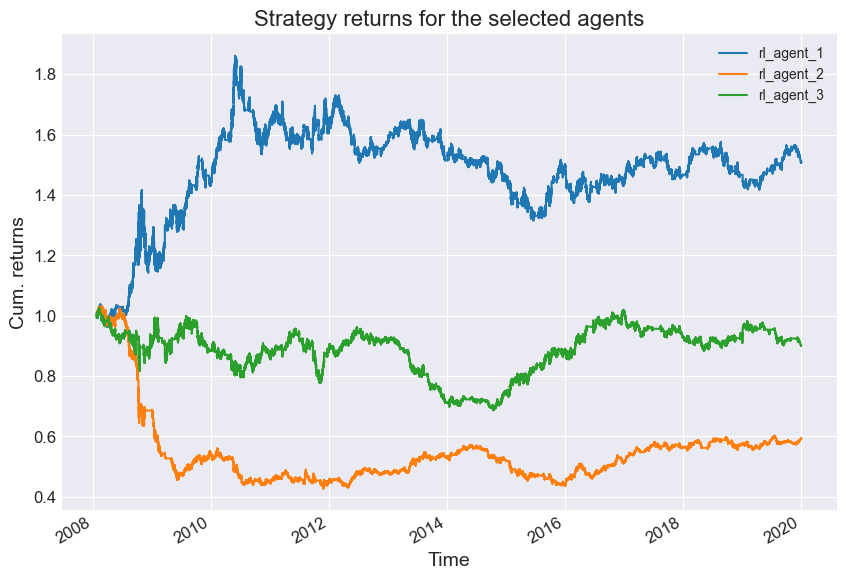

In [6]:
# Plotting individual agent's performance
(selected_agents+1).cumprod().plot(figsize=(10,7))
plt.legend()

# Add labels
plt.ylabel('Cum. returns', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Strategy returns for the selected agents', fontsize=16)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

<a id='rolling'></a> 
## Get the agent's rolling performance

We calculate and plot the positive rolling returns for the agents. The rolling window is initially chosen as 30000 bars and can be changed by you.

Negative returns are omitted (by setting it to 0) as they will result in incorrect weight allocation of the agents in the strategy. 

#### Please change the below cell to a code type to run it.

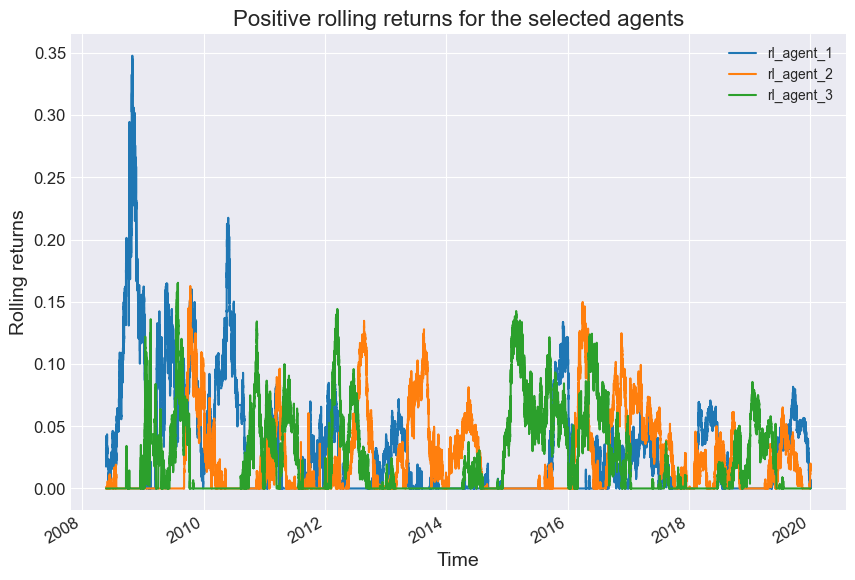

In [8]:
# Positive rolling returns for the agents
roll_returns_df = selected_agents.rolling(window=30000).sum()
roll_returns_df[roll_returns_df < 0] = 0

# Plotting positive rolling returns
roll_returns_df.plot(figsize=(10,7))
plt.legend()

# Add labels
plt.ylabel('Rolling returns', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Positive rolling returns for the selected agents', fontsize=16)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

<a id='weights'></a> 
## Allocate portfolio weight based on the performance

We calculate and plot the weight allocation of the agents in the strategy.

The weight allocation is updated every 1500 data bars in this model solution. You can tweak this parameter and analyse the returns further.

#### Please change the below cell to a code type to run it.

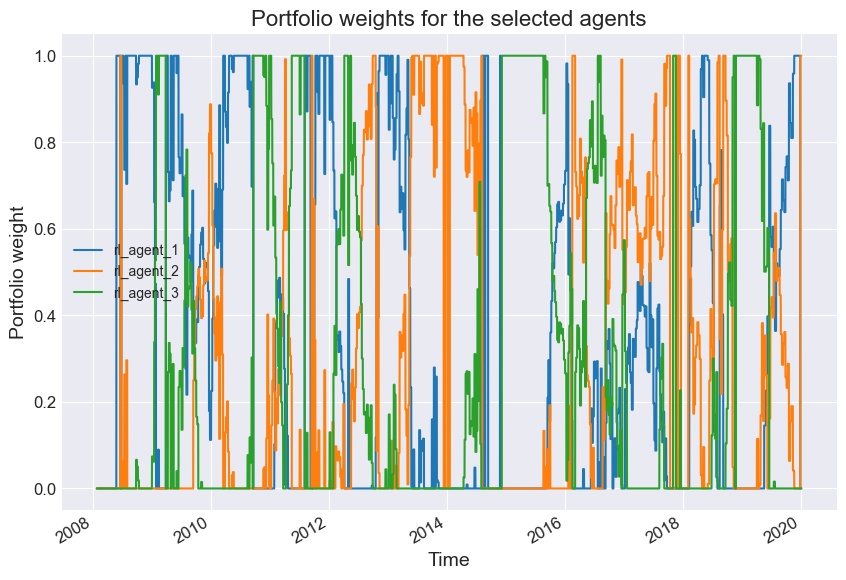

In [10]:
# Weight allocation of the agents on the basis of the positive rolling returns
wt_df = roll_returns_df.div(roll_returns_df.sum(axis=1), axis='rows').fillna(0)
wt_df.loc[~wt_df.index.isin(wt_df[::1500].index)] = np.nan
wt_df = wt_df.fillna(method='ffill')

# Plotting weights of the individual agents
wt_df.plot(figsize=(10,7))
plt.legend()

# Add labels
plt.ylabel('Portfolio weight', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Portfolio weights for the selected agents', fontsize=16)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

<a id='performance'></a> 
## Performance analysis

The strategy returns are then plotted against the selected agents for comparison.

We then use pyfolio package to generate the performance metrics.

#### Please change the below cell to a code type to run it.

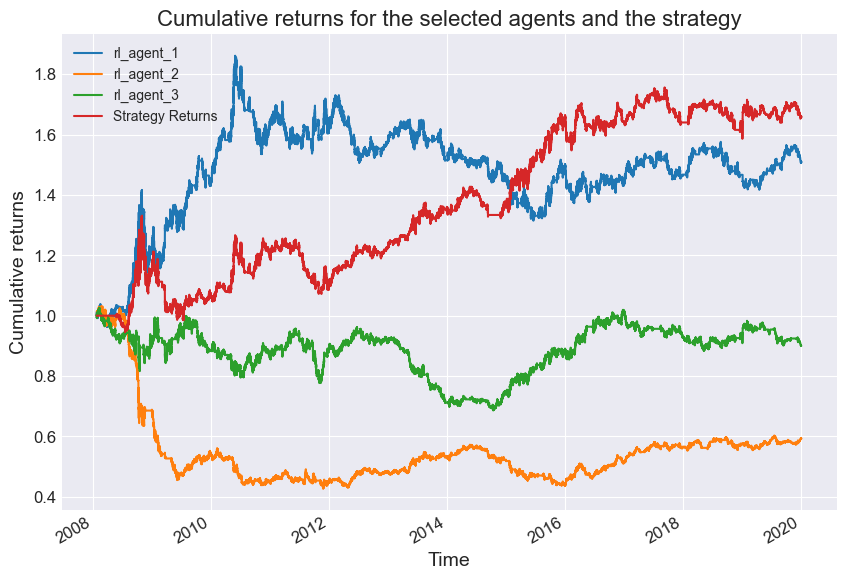

In [12]:
strategy_returns = (selected_agents*wt_df.shift(1)).dropna().sum(axis=1)
(selected_agents+1).cumprod().plot(figsize=(10,7))

# Plotting strategy along with the individual agents
(strategy_returns+1).cumprod().plot(label='Strategy Returns', figsize=(10,7))
plt.legend()

# Add labels
plt.ylabel('Cumulative returns', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Cumulative returns for the selected agents and the strategy', fontsize=16)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

#### Please change the below cell to a code type to run it.

Start date,2008-01-22
End date,2020-01-02
Total months,207
,Backtest
Annual return,3.258%
Cumulative returns,74.222%
Annual volatility,8.284%
Sharpe ratio,0.43
Calmar ratio,0.13
Stability,0.93
Max drawdown,-24.577%


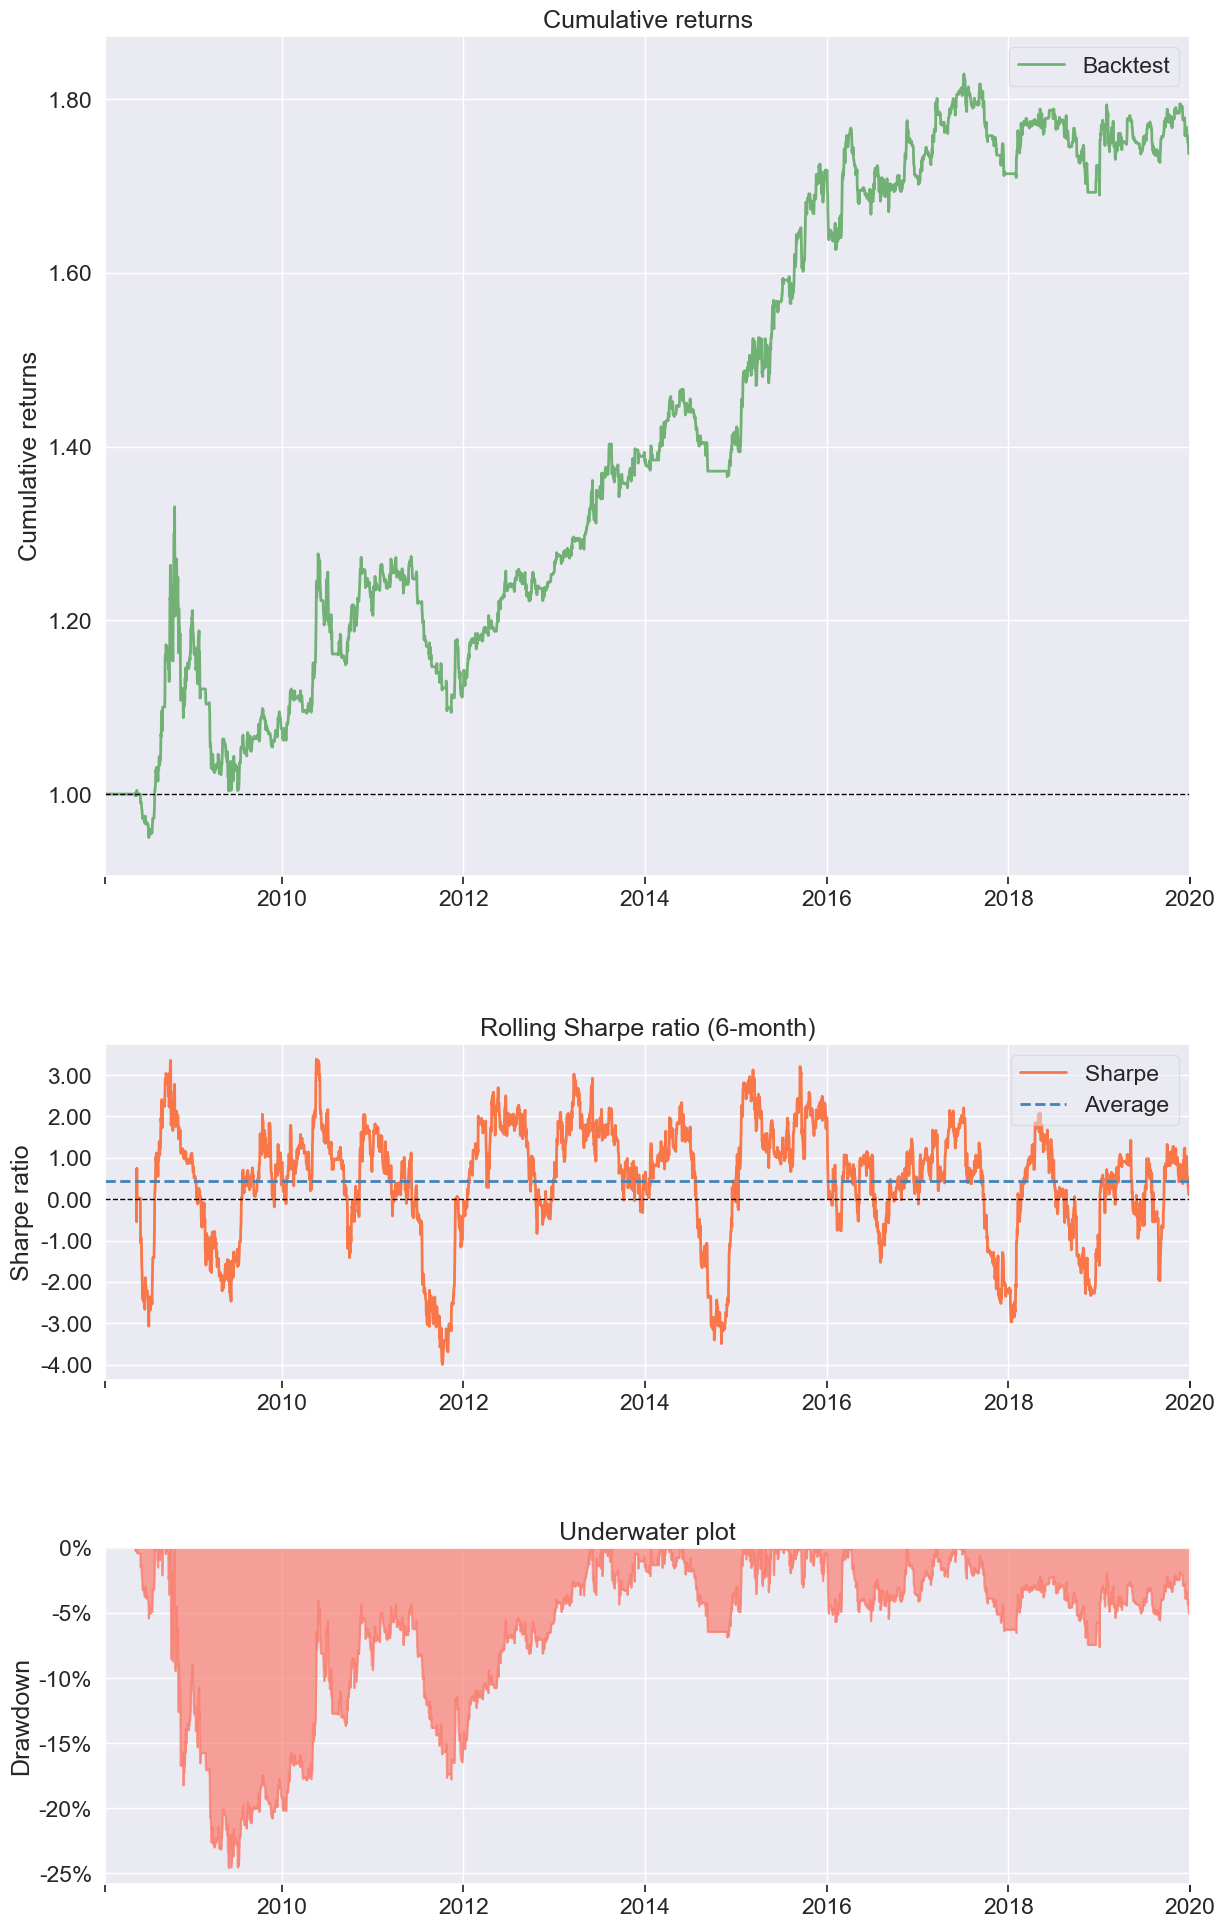

In [14]:
pf.create_simple_tear_sheet(strategy_returns.resample('1D').sum())

<a id='conclusion'></a> 
## Conclusion

This strategy creation demonstrates that the overall performance is better using a combination of agents rather than selecting a single best performing agent. You can try more ways to select the agents on basis of various performance metrics.